$$ \LaTeX \text{ command declarations here.}
\newcommand{\N}{\mathcal{N}}
\newcommand{\R}{\mathbb{R}}
\renewcommand{\vec}[1]{\mathbf{#1}}
\newcommand{\norm}[1]{\|#1\|}
\newcommand{\d}{\mathop{}\!\mathrm{d}}
\newcommand{\qed}{\qquad \mathbf{Q.E.D.}}
\newcommand{\vx}{\mathbf{x}}
\newcommand{\vy}{\mathbf{y}}
\newcommand{\vt}{\mathbf{t}}
\newcommand{\vb}{\mathbf{b}}
\newcommand{\vw}{\mathbf{w}}
\newcommand{\vm}{\mathbf{m}}
\newcommand{\I}{\mathbb{I}}
\newcommand{\th}{\text{th}}
$$

In [1]:
%matplotlib inline
from Lec09 import *

# EECS 545:  Machine Learning
## Lecture 09:  Kernel Methods
- Instructor:  **Jacob Abernethy**
- Date:  February 8, 2016


*Lecture Exposition Credit*:  Benjamin Bray, Saket Dewangan

## Outline

- Feature Mapping
    - Regression
    - Classification
- Kernel Methods
    - Kernel functions
    - Kernel trick
    - Constructing kernels
- Dual Representation using Kernels
    - Linear Regression
- Kernel Regression       

## Reading List

- Required:
    - **[PRML]**, §6.1: Dual Representation
    - **[PRML]**, §6.2: Constructing Kernels
    - **[PRML]**, §6.3: Radial Basis Function Networks

- Optional:    
    - **[MLAPP]**, §14.2: Kernel Functions
    - [**Everything You Wanted to Know about the Kernel Trick (But were too Afraid to Ask)**](http://www.eric-kim.net/eric-kim-net/posts/1/kernel_trick.html)

> In this lecture, we will cover kernel methods. For feature mapping $\phi(\vx)$, we will see mapping features to higher dimensional space is advantageous in machine learning, but higher dimension brings greater computational complexity. The kernel trick, our protagonist, comes to the rescue, with the ability to implicitly handle higher dimensional features at low cost. We will see how kernel functions are defined, how to construct kernels and how to use the kernel trick in machine learning. Kernels give us a dual representation of learning algorithms which entirely written in terms of kernel functions. Particularly, we will show how to transform regularized linear regression into a dual representation. Finally we review cover kernel regression, a technique similar to locally weighted least squares.

## Feature Mapping


### Review:  Feature Mapping

- **Feature mapping** $\phi(\vx) : \mathcal{X} \mapsto \R^M$ maps data into a feature space.
    - In general, features are nonlinear functions of the data
        - Recall we use polynomial features in linear regression
    - It could be that $\phi(\vx) = \vx$, i.e. no mapping exists
    - Each feature $\phi_j(\vx)$ extracts important properties from $x$
    - Feature mapping could boost the performance of learning algorithms.

### Feature Mapping: Linear Regression

- Without feature mapping, linear model $y(\vx) = w^T \vx$ can only produce straight lines through origin.
    - Not very flexible / powerful and can't handle nonlinearities
- We could replace $\vx$ by $\phi(\vx) = (\vx, \vx^2, \cdots, \vx^p)$, so $y(\vx) = w^T \phi(\vx)$
    - An appropriate feature mapping could generate nice regressor, eg. p=5 in the following plots
- Note that in this lecture, notation $(x_1, x_2, \cdots, x_N)$ denote a column vector.

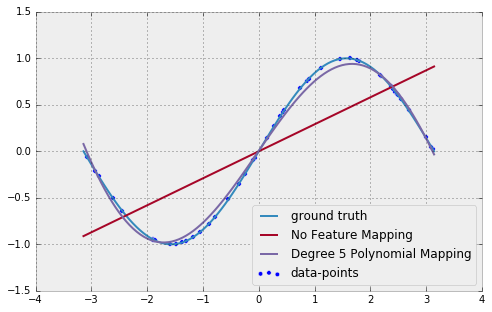

In [2]:
poly_reg_example();

### Feature Mapping: Linear Classification

- **Recall:**  Linear (binary) classifiers separate data with a **hyperplane** in feature space,
    $$
    h(\vx) = \begin{cases}
    1 & \text{if } \vw^T \phi(\vx) > 0 \\
    0 & \text{otherwise}
    \end{cases}
    $$

- **Examples:** Differ only in how the weights $w$ are learned.
    - Logistic regression, LDA(GDA with shared covariance), Fisher's Linear Discriminant, Perceptron (Lec 07 & 08).

### Feature Mapping: Linear Classification

- **Problem:**  The following data is **NOT** linearly separable if we want to learn a linear classifier with form $h(\vx) = \vw^T \vx$

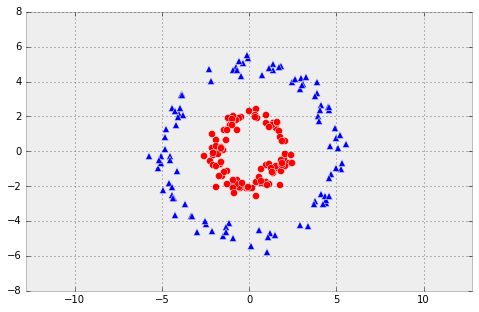

In [3]:
plot_circular_data(100);

- $\vx = (x_1, x_2)$, so $\vw^T \vx = w_1 x_1 + w_2 x_2$ which is a straight line through the origin.
- Obviously, no linear classifier can separate the blue rectangles from the red circles.

### Feature Mapping: Linear Classification

- **Solution 1 (Left):**  Add squared-distance-to-origin $(x_1^2 + x_2^2)$ as third feature. So $\phi(\vx) = (x_1, x_2, x_1^2 + x_2^2)$
- **Solution 2 (Right):**  Use features $\phi(\vx) = (x_1^2, x_2^2)$

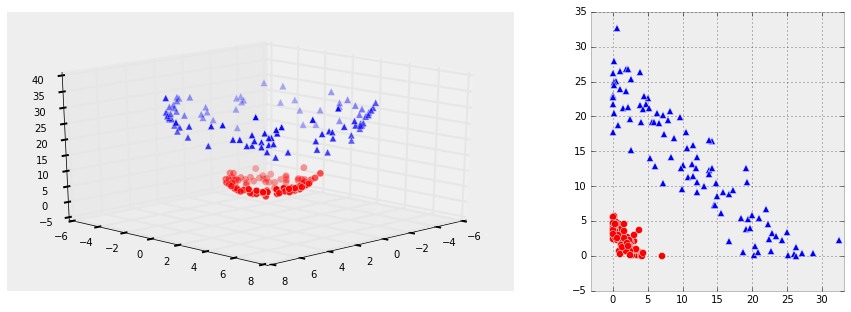

In [4]:
plot_solution()

- Linear **separable** now with the new features!

### Feature Mapping:  Advantages

- From examples of regression and classification, we see

    - Data has been mapped via $\phi(\vx)$ to a new, higher-dimensional (possibly infinite!) space

    - Certain *mapping* are better for certain problems


### Feature Mapping:  Disadvantages

- High feature dimension $M$ brings high computational complexity
    - Recall in regularized linear regression, we have solution
    $$
    \vw = (\Phi^T\Phi + \lambda I)^{-1} \Phi^T \vt
    $$
    Design matrix $\Phi \in \R{N \times M}$ of which $N$ is number of samples and $M$ is number features
    - $\Phi^T\Phi \in \R^{M \times M}$
    - Inversion $(\Phi^T\Phi + \lambda I)^{-1}$ has complexity $O(M^3)$ !

- We can never handle features with *infinite* dimension

- **Kernel** methods come to the rescue
    - Implicitly handle high dimensional features with low computational complexity
    - Even possible to handle *infinite* dimensional features (we will see later)

## Kernel Methods

> Uses content from **[PRML]** and [Wikipedia, "Kernel Method"](https://en.wikipedia.org/wiki/Kernel_method)

### Kernel Methods:  Intro

- Many algorithms depend on the data only through pairwise **inner products** between data points,
    $$
    \langle \vx_1, \vx_2 \rangle = \vx_2^T \vx_1
    $$
    - Inner product represents *similarity* between data points.

- Inner products can be replaced by **Kernel Functions**, capturing more general notions of similarity.
    - No longer need coordinates!

### Kernel Functions:  Definition

- A **kernel function** $\kappa(\vx,\vx’)$ is intended to measure the similarity between $\vx$ and $\vx’$.
    - Eg. $\vx^T \vx'$, $(\vx^T \vx')^p$,$\ \norm{\vx-\vx'}^2$, $\ \exp \left( \frac{\norm{\vx-\vx'}^2}{2\sigma^2} \right)$

- In general, a **valid** kernel function $\kappa(\vx, \vx')$ satisfies that for every set $\vx_1, \dots, \vx_N$, the matrix 
    $$
    \begin{bmatrix}
    \kappa(\vx_1, \vx_1) & \kappa(\vx_1, \vx_2) & \cdots & \kappa(\vx_1, \vx_N)\\ 
    \kappa(\vx_2, \vx_1) & \kappa(\vx_2, \vx_2) & \cdots & \kappa(\vx_2, \vx_N)\\ 
    \vdots & \vdots & \ddots & \vdots \\ 
    \kappa(\vx_N, \vx_1) & \kappa(\vx_N, \vx_2) & \cdots & \kappa(\vx_N, \vx_N)
    \end{bmatrix}
    $$ 
    is a **positive-semidefinite** (PSD) matrix.

### Kernel Functions:  Kernel Function $\leftrightarrow$ Implicit Feature Mapping

- For every **valid** kernel function $\kappa(\vx, \vx')$, there exists an implicit feature mapping $\phi(x)$ such that
    $$
    \kappa(\vx, \vx') = \phi(\vx)^T \phi(\vx')
    $$
    - Kernel function corresponds to inner product of features in some high-dimensional space
    - We will show this with some examples

- The converse is also **true**. Given some feature mapping $\phi(\vx)$, then $\kappa(\vx, \vx')$ defined by
    $$
    \kappa(\vx, \vx') = \phi(\vx)^T \phi(\vx')
    $$
    is a valid kernel function

- We could prove a kernel is valid by finding an implicit feature mapping!

- The *incredible* result above follows from **Mercer's Theorem**,
    - Generalizes the fact that *every positive-definite matrix corresponds to an inner product*
    - For more info, see Hsing & Eubank 2015, ["Theoretical Foundations of Functional Data Analysis"](http://www.wiley.com/WileyCDA/WileyTitle/productCd-0470016914.html)

### Kernel Functions:  Example—Quadratic Polynomial Kernel

- **Kernel:** For $\vx = (x_1, x_2)$ and $\vx'=(x_1', x_2')$, define
    $$
    \begin{align}
    \kappa(\vx, \vx')
    &= (\vx^T \vx')^2 \\
    &= (x_1x_1' + x_2x_2')^2 \\
    &= x_1^2x_1'^2 + 2x_1  x_2 x_1' x_2' + x_2^2 x_2'^2 
    \end{align}
    $$
    
- **Mapping:**  Equivalent to the standard inner product when either
    $$
    \begin{gather}
    \phi(\vx) = (x_1^2, \sqrt{2} x_1 x_2, x_2^2) \\
    \phi(\vx) = (x_1^2, x_1 x_2, x_1 x_2, x_2^2)
    \end{gather}
    $$

- Implicit mapping is **not** unique!

- Note $\vx$ and $\vx'$ denote two data points. $\vx'$ does **NOT** denote transpose of $x$ here.

### Kernel Functions:  Example—Polynomial Kernel

- **Kernel:** Higher-order polynomial of degree $p$,
    $$
    \kappa(\vx,\vx')
    = (\vx^T \vx')^p
    = \left( \sum_{k=1}^M x_k x_k' \right)^p
    $$

- **Mapping:** Implicit feature vector $\phi(\vx)$ contains all monomials of degree $p$

- **Example:** For $\vx = (x_1, x_2)$, $\vx'=(x_1', x_2')$ 
    - When $p=2$, as previous example, we have
        $$
        \phi(\vx) = (x_1^2, x_2^2, \sqrt{2} x_1 x_2)
        $$
    - When $p=3$, we have
        $$
        \phi(\vx) = (x_1^3, x_2^3, \sqrt{3}x_1^2 x_2, \sqrt{3} x_1 x_2^2)
        $$
        
- Try to verify this!

### Kernel Functions:  Example—Generalized Polynomial Kernel

- **Kernel:** Inhomogeneous polynomial up to degree $p$, for $c > 0$,
    $$
    \kappa(\vx,\vx')
    = (\vx^T \vx' + c)^p
    = \left(c + \sum_{k=1}^M \vx_k \vx_k' \right)^p
    $$

- **Mapping:** Implicit feature vector $\phi(\vx)$ contains all monomials of degree $\leq p$

- **Example:** For $\vx = (x_1, x_2)$, $\vx'=(x_1', x_2')$ 
    - When $p=2$, we have
        $$
        \phi(\vx) = (x_1^2, x_2^2,  \sqrt{2} x_1 x_2  ,\sqrt{2} \sqrt{c} x_1, \sqrt{2} \sqrt{c} x_2, c)
        $$
    - When $p=3$, we have
        $$
        \phi(\vx) = (x_1^3, x_2^3, \sqrt{c}^3, \sqrt{3}x_1^2 x_2, \sqrt{3} x_1^2 \sqrt{c}, \sqrt{3} x_2^2 x_1, \sqrt{3} x_2^2 \sqrt{c}, \sqrt{3} c x_1, \sqrt{3} c x_2, \sqrt{6} x_1 x_2 \sqrt{c})
        $$
    - Note that we could view $\kappa(\vx,\vx')$ as $(\tilde{\vx}^T \tilde{\vx}')^p$ of which $\tilde{\vx} = (\vx, \sqrt{c})$ and $\tilde{\vx}' = (\vx', \sqrt{c})$
        
- Try to verify this!

### Kernel Functions:  Example—Gaussian Kernel

- **Kernel:**
    $$
    \kappa(\vx,\vx')= \exp \left( -\frac{\norm{\vx-\vx'}^2}{2 \sigma^2} \right)
    $$

- **Mapping:** Implicit feature vector $\phi(\vx)$ has **infinite** dimension!

- **Not related to Gaussian pdf!**

- Translation invariant (depends only on distance between points)
        
- Derivation of infinite dimension feature is in the notes

> **Remark**
> - Derivation of infinite features of Gaussian Kernel

>     - Expand the Gaussian kernel:
        $$
        \kappa(\vx,\vx')= \exp \left( -\frac{\norm{\vx-\vx'}^2}{2 \sigma^2} \right) 
        = \exp\left(- \frac{\norm{\vx}^2}{2 \sigma^2}\right) \exp\left(\frac{ \vx^T \vx' }{\sigma^2}\right) \exp\left(- \frac{\norm{\vx'}^2}{2 \sigma^2}\right)
        $$
        of which
        $$
        \exp\left(\frac{ \vx^T \vx' }{\sigma^2}\right) = \sum \nolimits_{n=0}^\infty \frac{1}{n!} \left( \frac{\vx^T \vx'}{\sigma^2} \right)^n
        = \sum \nolimits_{n=0}^\infty \frac{1}{n! \sigma^{2n}} \left( \vx^T \vx' \right)^n
        $$
        
>     - We already know $(\vx^T \vx')^n$ is a valid kernel. So let $\psi_n(\vx)$ denote the feature mapping of $(\vx^T \vx')^n$, i.e.
        $$
        \psi_n(\vx)^T \psi_n(\vx) = (\vx^T \vx')^n
        $$
        Then we have
        $$
        \begin{split}
        & \exp\left(\frac{ \vx^T \vx' }{\sigma^2}\right) 
        = \sum \nolimits_{n=0}^\infty \frac{1}{n! \sigma^{2n}} \psi_n(\vx)^T \psi_n(\vx) \\
        &= \left( \sqrt{\frac{1}{0!}} \psi_0(\vx), \sqrt{\frac{1}{1! \sigma^2}} \psi_1(\vx), \dots, \sqrt{\frac{1}{n! \sigma^{2n}}} \psi_n(\vx)  \right)^T \left( \sqrt{\frac{1}{0!}} \psi_0(\vx'), \sqrt{\frac{1}{1! \sigma^2}} \psi_1(\vx'), \dots, \sqrt{\frac{1}{n! \sigma^{2n}}} \psi_n(\vx')  \right) \\
        &\triangleq \eta(\vx)^T \eta(\vx')
        \end{split}
        $$
        of which $\eta(\vx)$ is a new feature mapping with **infinite** dimension.

>     - So
        $$
        \kappa(\vx,\vx') = \exp\left(- \frac{\norm{\vx}^2}{2 \sigma^2}\right)  \eta(\vx)^T \eta(\vx')  \exp\left(- \frac{\norm{\vx'}^2}{2 \sigma^2}\right) \triangleq \phi(\vx)^T \phi(\vx')
        $$
        of which $\phi(\vx) = \exp\left(- \frac{\norm{\vx}^2}{2 \sigma^2}\right)  \eta(\vx)$ is the final infinite dimension feature mapping of $\kappa(\vx,\vx')$

### Kernel Functions: Handwritten Example
- For $28 \times 28$ handwritten image below
<img src="images/hand_writ_example.png" width=150px, align="middle">

- Take the pixel values and compute $\kappa(\vx, \vx') = (\vx^T \vx' + 1)^p $
    - here, $\vx$ is the vectorized image, which has $28 \times 28 = 784$ pixels  
- According to the generalized polynomial kernel, for $\text{dim}(\vx) = 784$ and $p=4$, the dimension of features $\text{dim}(\phi(x)) \approx 1.6 \times 10^{10}$!

- **Reacall**, high-dimensional feature could boost the performance of machine learning algorithm

    - Kernel Functions will be the bridge!
    
- But before we apply kernel functions to ML algorithms, let's first see how to construct kernels.    

> **Remark**
> - How is the $1.6 \times 10^{10}$ computed?

>     - Define $\tilde{\vx} = (\vx, 1) \in \R^{785}$ and $\tilde{\vx}' = (\vx', 1) \in \R^{785}$, so we have
        $$
        \begin{align}
        \kappa(\vx, \vx') 
        &= (\tilde{\vx}^T \tilde{\vx}')^4 = (\sum \nolimits_{i=1}^{785} \tilde{x}_i \tilde{x_i}')^4 \\
        &= (\tilde{x}_1 \tilde{x}_1' + \tilde{x}_2 \tilde{x}_2' + \cdots + \tilde{x}_{785} \tilde{x}_{785}')^4 \\
        &\triangleq (y_1 + y_2 + \cdots + y_{785})^4
        \end{align}
        $$
        
>     - The dimension equals the number of monomials with degree 4.

>     - It's just a combinatoric problem. Now lets count.

>     - In the table, $m,n,p,q$ are *distinct* and $m,n,p,q = 1,2,\dots, 785$.
>
| Monomial Combination | $ \ \ \ \ y_m^4  \ \ \ \ $  | $y_m^3y_n$ | $ \ \  y_m^2 y_n^2 \ \ $ | $ y_m^2 y_n y_p $  | $y_m y_n y_p y_q$ |
| -------------------- | :-------------: | :-------------: | :-------------: | :-------------: | :-------------: |
| Counting     | $\binom{785}{1}$  | $\binom{785}{2} \binom{3}{1}$ |  $ \binom{785}{2} $  | $\binom{785}{3} \binom{3}{1}$ | $\binom{785}{4}$ |
>
>
> - Add them up, we could get $1.59 \times 10^{10}$

### Kernel Functions: Constructing Kernels

- **Method 1:** Explicitly define a feature space mapping $\phi(\vx)$ and use **inner product kernel**
    $$
    \kappa(\vx,\vx')
    = \phi(\vx)^T \phi(\vx')
    = \sum_{i=1}^{M}\phi_i(\vx) \phi_i(\vx')
    $$

- **Method 2:** Explicitly define a kernel $\kappa(\vx,\vx')$ and identify the implicit feature map, e.g.
    $$
    \kappa(\vx,\vx') = (\vx^T \vx')^2
    \quad \implies \quad
    \phi(\vx) = (\vx_1^2, \sqrt{2} \vx_1 \vx_2, \vx_2^2)
    $$
    - Kernels help us avoid the complexity of explicit feature mappings.

- **Method 3:** Define a similarity function $\kappa(x, x')$ and use **Mercer's Condition** to verify that an implicit feature map *exists* without finding it.
    - Define the Gram matrix $K$ to have elements $K_{nm} = \kappa(\vx_n,\vx_m)$
    - Then $K$ must be **positive semidefinite** for all possible choices of the data set {$x_n$}, i.e.
    
    $$
    a^TKa
    \equiv \sum_{i}\sum_{j} a_i K_{ij} a_j \geq 0 \quad \forall\, a \in \R^n
    $$ 

### Kernel Functions: Building Blocks

- Given valid kernels $\kappa_1(\vx, \vx')$ and $\kappa_2(\vx, \vx')$, the following new kernels will also be valid:
    $$
    \boxed{
    \begin{split}
    \kappa(\vx, \vx') &= c\kappa_1(\vx, \vx') & & \text{Constant } c>0\\
    \kappa(\vx, \vx') &= f(\vx) \kappa_1(\vx, \vx') f(\vx') & & \forall \text{ function } f(\cdot)\\
    \kappa(\vx, \vx') &= q(\kappa_1(\vx, \vx')) & & \forall \text{ polynomail } q(\cdot) \text{ with nonnegative coeffs}\\
    \kappa(\vx, \vx') &= \exp(\kappa_1(\vx, \vx')) \\
    \kappa(\vx, \vx') &= \kappa_1(\vx, \vx') + \kappa_2(\vx, \vx') \\
    \kappa(\vx, \vx') &= \kappa_1(\vx, \vx')\kappa_2(\vx, \vx') \\
    \kappa(\vx, \vx') &= \kappa_1(\phi(\vx), \phi(\vx')) & & \phi(\vx) \text{ is any feature mapping}\\
    \kappa(\vx, \vx') &= \vx^T A \vx & & A \text{ is any symmetric positive semidefinite matrix}\\    
    \end{split}}
    $$

- Popular Kernel Functions
    $$
    \begin{align}
    \kappa(\vx, \vx') &= (\vx^T \vx')^p \\
    \kappa(\vx, \vx') &= (\vx^T \vx' + c)^p & &c>0\\
    \kappa(\vx, \vx') &= \exp \left( -\frac{\norm{\vx-\vx'}^2}{2 \sigma^2} \right)
    \end{align}
    $$

### Kernel Methods: Kernel Trick

- So far, we have seen 
    - kernel is related to high-dimension features
    - how to construct features.

- **But**, how to apply kernels to ML algorithm?

- **Idea:** if an algorithm is formulated in such a way that the $\vx$ enters only through inner product, then we can replace the inner product with some other choice of kernel.
    - i.e. $\vx^T \vx' \text{ or } \phi(\vx)^T \phi(\vx') \rightarrow \kappa(\vx, \vx')$

    - This is called **kernel trick** or **kernel substitution**

    - To use the kernel trick, we must formulate algorithms purely in terms of inner products between data points

    - We can *not* access the coordinates of points in the high-dimensional feature space

    - This seems a huge limitation, but it turns out that quite a lot can be done

- By using different definitions for inner product, we can manipulate features in high dimensional space with only the computational complexity of a low dimensional space.

### Kernel Trick: Example—Distance

- Distance between samples can be expressed in inner products:
    $$
    \begin{align}
    ||\vx - \vx' ||^2
    &= \langle\vx- \vx', \vx- \vx' \rangle\\
    &= \langle \vx, \vx\rangle - 2\langle\vx, \vx' \rangle + \langle\vx, \vx' \rangle \\
    \end{align}
    $$
    After kernel substitution, we have
    $$
    ||\vx - \vx' ||^2 = \kappa(\vx,\vx) - 2\kappa(\vx,vx') + \kappa(\vx',\vx')
    $$

- With kernels, we are no longer limited to distance defined by $\ell_2$ norm.

- This generalzied distance can be used in distance-based algorithm, eg. **k-nearest neighbor searches**.


### Kernel Trick: Example—Distance to the Mean

* Mean of data points given by: $\bar{\vx}= \frac{1}{N}\sum_{i=1}^{N}\vx_i$

* Distance to the mean:
    $$
    \begin{align}
    ||\vx - \bar{\vx}||^2
    &= \langle\vx- \bar{\vx}, \vx- \bar{\vx} \rangle\\
    &= \langle \vx, \bar{\vx}\rangle - 2\langle\vx, \bar{\vx}\rangle + \langle\bar{\vx}, \bar{\vx} \rangle \\
    &= \kappa(\vx,\vx) - \frac{2}{N}\sum_{i=1}^{N}\kappa(\vx,\vx_i) + \frac{1}{N^2}\sum_{j=1}^{N}\sum_{i=1}^{N}\kappa(\vx_i,\vx_j)
    \end{align}
    $$


### Kernel Trick: Question

**Question:**  Can you determine the **mean** of data in the mapped feature space through kernel operations only?

**Answer:** No, you cannot compute any point explicitly.

## Dual Representations: Linear Regression

> Following **[PRML]** Chapter 6.1

### Dual Representations: Linear Regression

- In this part, we will transform lienar regression into its dual representation    
    - i.e. express the algorithm entirely with kernels
    - Same as kernel substitution, we will replace inner product with kernels.

- **Review**
    - The solution to regularized linear regression is
        $$
        \vw = \left( \Phi^T \Phi + \lambda I_M \right)^{-1} \Phi^T \vt
        $$
        of which 
        $$
        \Phi = \begin{bmatrix} - & \phi(\vx_1)^T & -\\  & \vdots & \\  - & \phi(\vx_N)^T & - \end{bmatrix}_{N \times M}
        \qquad
        I_M = \begin{bmatrix} 1 &  & \\  & \ddots & \\  &  & 1 \end{bmatrix}_{M \times M}
        \qquad
        \vt = \begin{bmatrix}
        t_1\\ 
        \vdots\\
        t_N
        \end{bmatrix}_{N \times 1}
        $$
        Recall $\Phi$ is **design** matrix. $N$ is number of data points. $M$ is dimension of features.
        
    - The prediction is $y(\vx) = \vw^T \phi(\vx)$

- **Preliminary**
    - Matrix Inversion Lemma (We will use twice later!)
    $$
    (A + UCV)^{-1} = A^{-1} - A^{-1}U(C^{-1} + VA^{-1}U)^{-1}VA^{-1}
    $$    

### Dual Representations: Derivation
- Using matrix inversion lemma 
    $$
    (A + UCV)^{-1} = A^{-1} - A^{-1}U(C^{-1} + VA^{-1}U)^{-1}VA^{-1}
    $$
    to expand the solution:    
    $$
    \begin{split}
    \vw 
    &= \left( \lambda I_M  + \Phi^T I_N \Phi \right)^{-1} \Phi^T \vt \\
    &= \left[ \lambda^{-1} I_M - \lambda^{-1} I_M \Phi^T \left(I_N + \Phi \lambda^{-1} I_M \Phi^T \right)^{-1} \Phi \lambda^{-1} I_M \right] \Phi^T \vt \\
    &= \left[ \lambda^{-1} \Phi^T - \lambda^{-1} \Phi^T \left(\lambda I_N + \Phi \Phi^T \right)^{-1} \Phi \Phi^T \right]\vt \\
    &= \Phi^T \left[ \lambda^{-1} I_N - \lambda^{-1} \left(\lambda \left(\Phi \Phi^T\right)^{-1} + I_N \right)^{-1}  \right]\vt \\
    &= \Phi^T \left[ \lambda^{-1} I_N - \lambda^{-2} \left(\left(\Phi \Phi^T\right)^{-1} + \lambda^{-1} I_N \right)^{-1}  \right]\vt \\
    &= \Phi^T \left[ \left(\lambda I_N\right)^{-1} - \left(\lambda I_N\right)^{-1} I_N \left(\left(\Phi \Phi^T\right)^{-1} + I_N \left(\lambda I_N\right)^{-1} I_N \right)^{-1} I_N \left(\lambda I_N\right)^{-1}  \right]\vt \\
    \end{split}
    $$

### Dual Representations: Derivation

- Now let's use matrix inversion lemma backward:
    $$
    A^{-1} - A^{-1}U(C^{-1} + VA^{-1}U)^{-1}VA^{-1} = (A + UCV)^{-1}
    $$
    we have 
    $$
    \begin{split}
    \vw    
    &= \Phi^T \left[ \left(\lambda I_N\right)^{-1} - \left(\lambda I_N\right)^{-1} I_N \left(\left(\Phi \Phi^T\right)^{-1} + I_N \left(\lambda I_N\right)^{-1} I_N \right)^{-1} I_N \left(\lambda I_N\right)^{-1}  \right]\vt \\
    &= \Phi^T \left( \lambda I_N + \Phi \Phi^T \right)^{-1} \vt \\
    &\triangleq \Phi^T \vec{a}
    \end{split}
    $$
    of which $\vec{a} = \left( \lambda I_N + \Phi \Phi^T \right)^{-1} \vt \in \R^N$
    
- What is this $\vec{a}$?
    - It will take the place of $\vw$ and be the parameter in dual representation.
    - We will see shortly

### Dual Representations: Derivation

- The prediction is
    $$
    \begin{align}
    y(\vx)
    & = w^T \phi(\vx) = \vec{a}^T \Phi \phi(x) = \left[ \left( \lambda I_N + \Phi \Phi^T \right)^{-1} \vec{t} \right]^T \Phi \phi(x) \\
    & = \left[ \left( \lambda I_N + \begin{bmatrix}
    \phi(\vx_1)^T \phi(\vx_1) & \cdots & \phi(\vx_1)^T \phi(\vx_N)\\ 
    \vdots & \ddots & \vdots \\ 
    \phi(\vx_N)^T \phi(\vx_1) & \cdots & \phi(\vx_N)^T \phi(\vx_N)
    \end{bmatrix} \right )^{-1} \vt \right]^T
    \begin{bmatrix}
    \phi(\vx_1)^T \phi(\vx) \\
    \vdots\\ 
    \phi(\vx_N)^T \phi(\vx)\\ 
    \end{bmatrix} \\
    \end{align}
    $$
- Inner product appears! **Replace with kernels**!
- Define
    $$
    K = \Phi \Phi^T =\begin{bmatrix}
    \kappa(\vx_1, \vx_1) & \cdots & \kappa(\vx_1, \vx_1) \\ 
    \vdots & \ddots & \vdots \\ 
    \kappa(\vx_N, \vx_1) & \cdots & \kappa(\vx_N, \vx_N)
    \end{bmatrix}
    \qquad
    k(\vx) = \Phi \phi(\vx) = \begin{bmatrix} \kappa(\vx_1, \vx) \\ \vdots \\ \kappa(\vx_N, \vx) \end{bmatrix}
    $$
    So we have
    $$
    \boxed{
    \begin{gather}
    \vec{a} = \left( \lambda I_N + K \right)^{-1}\vt \\
    y(\vx) = \vec{a}^T k(\vx)
    \end{gather}
    }
    $$
- Inner products disappear and data enters only through kernels! 
    - This is exactly the **dual representation**!

### Dual Representations:  Primal vs. Dual

- **Primal**: 
    - **Parameter:** $\vw = (\Phi^T\Phi + \lambda I_M)^{-1} \Phi^T \vt$
    - **Prediction:** $y(\vx) = \vw^T \phi(\vx) $
        - invert $\Phi^T \Phi \in \R^{M \times M}$
        - cheaper since usually $N >> M$
        - must explicitly construct features

- **Dual**: 
    - **Parameter:** $ \vec{a} = (K + \lambda I_N)^{-1} \vt $
    - **Prediction:** $y(\vx) = \vec{a}^T k(\vx)$
        - invert Gram matrix $K = \Phi \Phi^T \in \R^{N \times N}$
        - use kernel trick to avoid feature construction
        - we could easily replace one kernel with another to represent similarity over vectors, images, sequences, graphs, text, etc..

## Kernel Regression

> For more details, see **[PRML]** Chapter 6.3

### Kernel Regression

- From training data $\{ (\vx_1,t_1), \dots, (\vx_N,t_N)\}$, **Kernel Regression** outputs:
    $$
    y(\vx) = \frac{1}{\sum_{n=1}^N \kappa(\vx_n, \vx)} \sum_{n=1}^N \kappa(\vx_n, \vx) t_n
    $$

- Approximates $y(\vx)$ with a weighted sum of nearby points
- Any distance kernel can be used
- A common practice is to use **Gaussian Kernel**:
    $$
    \kappa(\vx, \vx')
    = \exp \left\{-\frac{||\vx-\vx'||^2}{2\sigma^2} \right\}
    = \exp \left\{- \gamma ||\vx- \vx'||^2 \right\} 
    $$

### Kernel Regression:  Example—Linear + Noise

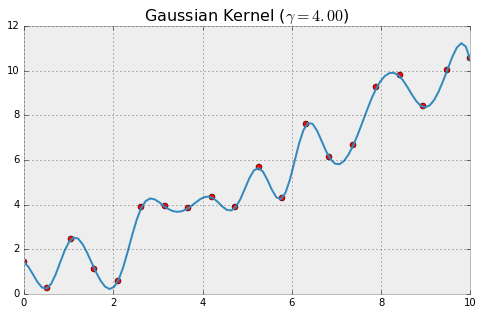

In [5]:
n = 20;    X = np.linspace(0,10,n)[:,np.newaxis];    y = (X + np.random.randn(n,1)).ravel();
plot_kernel_ridge(X, y,gamma=4,alpha=0.01);

### Kernel Regression:  Example—Sine + Linear + Noise

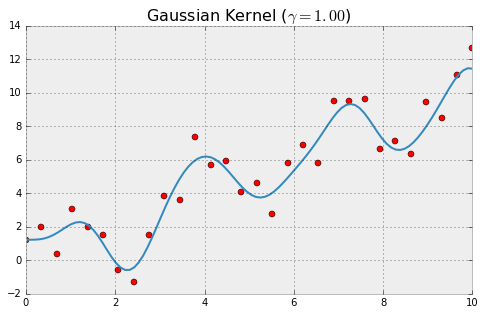

In [6]:
n = 30;    X = np.linspace(0,10,n)[:,np.newaxis];    y = (2*np.sin(X*2) + X + np.random.randn(n,1)).ravel();
plot_kernel_ridge(X, y, gamma = 1);

### Kernel Regression:  Example—Completely Random

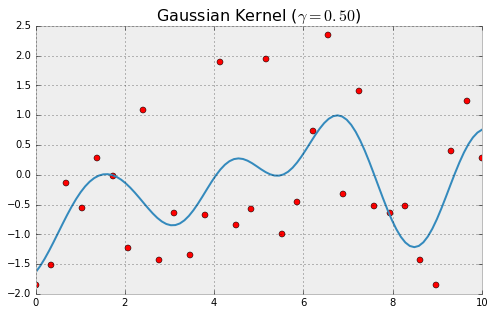

In [7]:
n = 30;    X = np.linspace(0,10,n)[:,np.newaxis];    y = (np.random.randn(n)).ravel();
plot_kernel_ridge(X, y);

### Kernel Regression:  Classification

- It is very easy to adapt kernel regression to **classification**!
- For data $\mathcal{D} = \{ (\vx_1,t_1), \dots, (\vx_N,t_N)\}$ and kernel $\kappa(\vx, \vx')$

    - **Regression**: if $t \in \R$ , return weighted average:
        $$
        y(\vx) = \frac{1}{\sum_{n=1}^N \kappa(\vx,\vx_n)} \sum_{n=1}^N \kappa(\vx, \vx_n) t_n
        $$

    - **Classification** if $t \in \pm 1$ , return weighted majority:
        $$ 
        h(\vx) = \mathrm{sign}\left( \sum_{n=1}^N \kappa(\vx,\vx_n) t_n \right)
        $$

### Comparison to Locally-Weighted Linear Regression

- Review **Locally-weighted Linear Regression**
    - Fit $\vw$ to minimize $\sum_{n=1}^N r_n (t_n - \vw^T \phi(\vx_n) )^2$ for weights $r_n$
    - Output $\vw^T \phi(\vx)$
 
- Standard choice for weight uses Gaussian Kernel, 
    $$
    r_n = \exp \left\{-\frac{||\vx_n - \vx||^2}{2\sigma^2} \right\}
    $$

### Comparison to Locally-Weighted Linear Regression

- **Similarities:**  Both methods are “instance-based learning”.
    - Only observations (training set) close to the query point are considered (highly weighted) for regression computation.
    - Kernel determines how to assign weights to training examples (similarity to the query point x)
    - Free to choose types of kernels
    - Both can suffer when the input dimension is high.
    
- **Differences:**
    - *LWLR:*  Weighted regression; slow, but more accurate
    - *KR:*  Weighted mean; faster, but less accurate    